In [4]:
#TODO: improve the sentiment classifier
#TODO: save the sentiment classifier to save time
#TODO: save the ngrams to save time
#TODO: explore the good and bad examples

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/tweet-sentiment-extraction/test.csv
/kaggle/input/tweet-sentiment-extraction/sample_submission.csv


In [6]:
df_data = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/train.csv")
df_test = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/test.csv")
df_sample_submission = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/sample_submission.csv")
print("df_data shape", df_data.shape,"\n", "df_test shape", df_test.shape)

df_data shape (27486, 4) 
 df_test shape (3535, 3)


In [7]:
df_data = df_data[~df_data.text.isnull()]
df_data.head()

,textID,text,selected_text,sentiment
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,neutral
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,neutral
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive


In [8]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_data["label"] = le.fit_transform(df_data.sentiment)
print(le.classes_)

['negative' 'neutral' 'positive']


In [9]:
df_data.head()

,textID,text,selected_text,sentiment,label
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,neutral,1
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive,2
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,neutral,1
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative,0
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive,2


In [10]:
from sklearn.model_selection import train_test_split

df_train, df_dev = train_test_split(df_data, test_size=0.2, random_state=42)
print(df_data.shape, df_train.shape, df_dev.shape)

(27485, 5) (21988, 5) (5497, 5)


In [11]:
y_train = df_train["label"]
y_dev = df_dev["label"]

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(df_train["selected_text"])
X_dev = vectorizer.transform(df_dev["selected_text"])

print(vectorizer.get_feature_names()[:10])
print(X_train.shape, X_dev.shape)
print(y_train.shape, y_dev.shape)

['00', '000', '007', '01', '02', '03', '04', '05', '06', '060']
(21988, 15142) (5497, 15142)
(21988,) (5497,)


In [56]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df_train["selected_text"])
X_train_tokenized = tokenizer.texts_to_sequences(df_train["selected_text"])
X_train = pad_sequences(X_train_tokenized)
print(X_train.shape)

(21988, 31)


In [13]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils import np_utils
from keras import regularizers

Using TensorFlow backend.


In [87]:
def baseline_lstm_model():
    embed_dim = 128
    lstm_out = 196

    model = Sequential()
    model.add(Embedding(max_fatures, embed_dim, input_length = X_train.shape[1]))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics = ['sparse_categorical_accuracy'])
    print(model.summary())
    return model

In [88]:
batch_size = 32
model = baseline_lstm_model()
model.fit(X_train, y_train, epochs=7, batch_size=batch_size)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 31, 128)           256000    
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 31, 128)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 591       
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________
None


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/7
21988/21988 [==============================] - 45s 2ms/step - loss: 0.6046 - sparse_categorical_accuracy: 0.7479
Epoch 2/7
21988/21988 [==============================] - 45s 2ms/step - loss: 0.4407 - sparse_categorical_accuracy: 0.8257
Epoch 3/7
21988/21988 [==============================] - 44s 2ms/step - loss: 0.4011 - sparse_categorical_accuracy: 0.8424
Epoch 4/7
21988/21988 [==============================] - 44s 2ms/step - loss: 0.3840 - sparse_categorical_accuracy: 0.8513
Epoch 5/7
21988/21988 [==============================] - 44s 2ms/step - loss: 0.3663 - sparse_categorical_accuracy: 0.8555
Epoch 6/7
21988/21988 [==============================] - 45s 2ms/step - loss: 0.3487 - sparse_categorical_accuracy: 0.8634
Epoch 7/7
21988/21988 [==============================] - 45s 2ms/step - loss: 0.3306 - sparse_categorical_accuracy: 0.8713


In [89]:
def text_to_sequence(df_column):
    X_tokenized = tokenizer.texts_to_sequences(df_column.values)
    X = pad_sequences(X_tokenized, maxlen=X_train.shape[1], dtype='int32', value=0)
    return X

X_dev = text_to_sequence(df_dev["selected_text"])
print(X_dev.shape)

(5497, 31)


In [91]:
score = model.evaluate(X_dev, y_dev, batch_size=32)
print(score)

5497/5497 [==============================] - 3s 572us/step
[0.4588489729923965, 0.8259050250053406]


In [92]:
df_dev.head()

,textID,text,selected_text,sentiment,label,number_of_words_in_text
7534,f07cf90a98,is missing out on the sunshine and trying to s...,is missing out on the sunshine and trying to s...,neutral,1,17
2664,95ce0e14ce,- i sure hope so it was worth it for me too ...,- i sure hope so it was worth it for me too ...,positive,2,13
12943,80775bf0e3,http://twitpic.com/4jccd - and also these hi t...,http://twitpic.com/4jccd - and also these hi t...,neutral,1,11
23884,60ce7c4890,The little weeping nervous girl was put throu...,The little weeping nervous girl was put throug...,neutral,1,24
4104,cc1af9564d,"maybe someday. i lova ya, friends!! my compute...","maybe someday. i lova ya, friends!! my compute...",neutral,1,16


In [93]:
df_dev["number_of_words_in_text"] = df_dev.text.str.split().str.len()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [97]:
try:
    df_ngrams = pd.read_pickle("df_ngrams.pkl")
except:
    df_ngrams = pd.DataFrame()
    for i in range(df_dev["text"].shape[0]):
        if i%1000==0:
            print(i)
        try:
            vectorizer_tmp = TfidfVectorizer(ngram_range=(1,df_dev.iloc[i]["number_of_words_in_text"]),token_pattern=r'\S+')
            ngrams = vectorizer_tmp.fit([df_dev.iloc[i]["text"]]).get_feature_names()
            df_tmp = pd.DataFrame({
                "textID":df_dev.iloc[i]["textID"],
                "selected_text":df_dev.iloc[i]["selected_text"],
                "selected_text_predict":ngrams,
                "label":df_dev.iloc[i]["label"]
            })
            df_ngrams = pd.concat([df_ngrams,df_tmp])
        except Exception as e:
            print("problem with ", i)
            pass

    #           print(e)
    df_ngrams.to_pickle("df_ngrams.pkl")
df_ngrams.shape

(615874, 4)

In [ ]:
X_to_predict = text_to_sequence(df_ngrams["selected_text_predict"])
y_pred = model.predict(X_to_predict, verbose=1)
y_pred.shape

In [71]:
df_ngrams["pred1"] = y_pred[:,0]
df_ngrams["pred2"] = y_pred[:,1]
df_ngrams["pred3"] = y_pred[:,2]

In [72]:
df_ngrams.loc[df_ngrams.label==0,"final_pred"] = df_ngrams.loc[df_ngrams.label==0,"pred1"] 
df_ngrams.loc[df_ngrams.label==1,"final_pred"] = df_ngrams.loc[df_ngrams.label==1,"pred2"] 
df_ngrams.loc[df_ngrams.label==2,"final_pred"] = df_ngrams.loc[df_ngrams.label==2,"pred3"] 

In [73]:
df_ngrams.head(10)

,textID,selected_text,selected_text_predict,label,pred1,pred2,pred3,final_pred
0,f07cf90a98,is missing out on the sunshine and trying to s...,2,1,0.159693,0.343380,0.496927,0.343380
1,f07cf90a98,is missing out on the sunshine and trying to s...,2 hours,1,0.086613,0.889480,0.023908,0.889480
2,f07cf90a98,is missing out on the sunshine and trying to s...,2 hours sleep,1,0.073678,0.894130,0.032192,0.894130
3,f07cf90a98,is missing out on the sunshine and trying to s...,after,1,0.076633,0.376148,0.547218,0.376148
4,f07cf90a98,is missing out on the sunshine and trying to s...,after having,1,0.155563,0.338103,0.506333,0.338103
5,f07cf90a98,is missing out on the sunshine and trying to s...,after having just,1,0.136050,0.544204,0.319746,0.544204
6,f07cf90a98,is missing out on the sunshine and trying to s...,after having just 2,1,0.047231,0.724387,0.228382,0.724387
7,f07cf90a98,is missing out on the sunshine and trying to s...,after having just 2 hours,1,0.021542,0.959485,0.018973,0.959485
8,f07cf90a98,is missing out on the sunshine and trying to s...,after having just 2 hours sleep,1,0.030434,0.941097,0.028470,0.941097
9,f07cf90a98,is missing out on the sunshine and trying to s...,and,1,0.271775,0.319666,0.408559,0.319666


In [74]:
df_ngrams["len_selected_text_predict"] = df_ngrams.selected_text_predict.str.len()
df_ngrams.sort_values(by=['len_selected_text_predict'], ascending=False, inplace=True)

In [75]:
idx = df_ngrams.groupby(['textID'])['final_pred'].transform(max) == df_ngrams['final_pred']

In [76]:
df_dev_final = df_ngrams[idx].drop_duplicates(subset='textID', keep="first")

In [77]:
df_dev_enriched = pd.merge(df_dev, df_dev_final[["textID","selected_text_predict"]], on='textID', how='left')

In [78]:
df_dev_enriched.loc[df_dev_enriched.selected_text_predict.isnull(),"selected_text_predict"] = df_dev_enriched.loc[df_dev_enriched.selected_text_predict.isnull(),"text"] 

In [79]:
# 58% is the accuracy when selected text is equal to text!! 

In [80]:
def jaccard(strs): 
    str1=strs['selected_text']
    str2=strs['selected_text_predict']
    
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

Average jaccard index in training data 0.4840155022496218


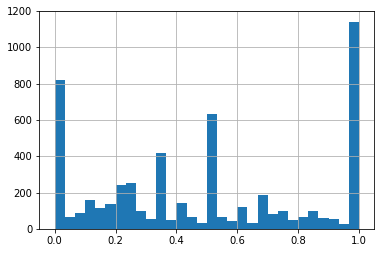

In [81]:
df_dev_enriched['jaccard']=df_dev_enriched[['selected_text','selected_text_predict']].apply(lambda x: jaccard(x),axis=1)

print(f"Average jaccard index in training data {df_dev_enriched['jaccard'].mean()}")
df_dev_enriched['jaccard'].hist(bins=30)

Average jaccard index in training data 0.5878679493589238


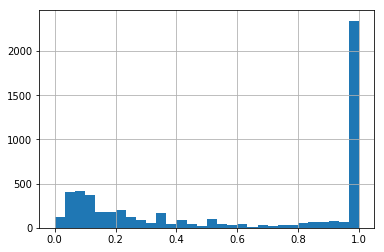

In [82]:
df_dev_enriched_baseline = df_dev_enriched.copy()
df_dev_enriched_baseline["selected_text_predict"]= df_dev_enriched_baseline["text"]
df_dev_enriched_baseline['jaccard']=df_dev_enriched_baseline[['selected_text','selected_text_predict']].apply(lambda x: jaccard(x),axis=1)
print(f"Average jaccard index in training data {df_dev_enriched_baseline['jaccard'].mean()}")
df_dev_enriched_baseline['jaccard'].hist(bins=30)

In [83]:
# Good predictions
print("Good Predictions\n__________")
df_sample = df_dev_enriched[df_dev_enriched.jaccard > .9]
for i in range(10):
    print("textID:    ", df_sample.iloc[i]["textID"])
    print("sentiment: ", df_sample.iloc[i]["sentiment"])
    print("original:  ", df_sample.iloc[i]["text"])
    print("target:    " , df_sample.iloc[i]["selected_text"])
    print("prediction:", df_sample.iloc[i]["selected_text_predict"])    
    print("--")
    
# Bad predictions
print("Bad Predictions\n__________")
df_sample = df_dev_enriched[df_dev_enriched.jaccard < .1]
for i in range(10):
    print("textID:    ", df_sample.iloc[i]["textID"])
    print("sentiment: ", df_sample.iloc[i]["sentiment"])
    print("original:  ", df_sample.iloc[i]["text"])
    print("target:    " , df_sample.iloc[i]["selected_text"])
    print("prediction:", df_sample.iloc[i]["selected_text_predict"])    
    print("--")

Good Predictions
__________
textID:     cc1af9564d
sentiment:  neutral
original:   maybe someday. i lova ya, friends!! my computer sucks  listening to coldplay&lt;3 tomorrow meet my bbff
target:     maybe someday. i lova ya, friends!! my computer sucks  listening to coldplay&lt;3 tomorrow meet my bb
prediction: maybe someday. i lova ya, friends!! my computer sucks listening to coldplay&lt;3 tomorrow meet
--
textID:     b7ca4a54c2
sentiment:  negative
original:   home from work today.....son is sick
target:     sick
prediction: sick
--
textID:     10c1f302a6
sentiment:  neutral
original:   Maybe going apartment shopping with Ashley?
target:     Maybe going apartment shopping with Ashley?
prediction: maybe going apartment shopping with ashley?
--
textID:     c92b5a0bf7
sentiment:  neutral
original:    ahh seen a few of those drop, but I just tossed them thinking it was a once only turn in
target:     ahh seen a few of those drop, but I just tossed them thinking it was a once only turn in

In [84]:
df_ngrams[df_ngrams.textID == "3e9e3f0d69"]

,textID,selected_text,selected_text_predict,label,pred1,pred2,pred3,final_pred,len_selected_text_predict
15,3e9e3f0d69,you're just altered forever Enjoy,"nah, you're just altered forever enjoy.",2,0.029375,0.023872,0.946753,0.946753,39
20,3e9e3f0d69,you're just altered forever Enjoy,you're just altered forever enjoy.,2,0.016366,0.008147,0.975486,0.975486,34
14,3e9e3f0d69,you're just altered forever Enjoy,"nah, you're just altered forever",2,0.265671,0.609038,0.125292,0.125292,32
19,3e9e3f0d69,you're just altered forever Enjoy,you're just altered forever,2,0.393168,0.397285,0.209547,0.209547,27
9,3e9e3f0d69,you're just altered forever Enjoy,just altered forever enjoy.,2,0.025442,0.003759,0.970799,0.970799,27
13,3e9e3f0d69,you're just altered forever Enjoy,"nah, you're just altered",2,0.089813,0.749649,0.160538,0.160538,24
2,3e9e3f0d69,you're just altered forever Enjoy,altered forever enjoy.,2,0.014485,0.001399,0.984116,0.984116,22
8,3e9e3f0d69,you're just altered forever Enjoy,just altered forever,2,0.742053,0.152044,0.105903,0.105903,20
18,3e9e3f0d69,you're just altered forever Enjoy,you're just altered,2,0.109926,0.434708,0.455366,0.455366,19
12,3e9e3f0d69,you're just altered forever Enjoy,"nah, you're just",2,0.089813,0.749649,0.160538,0.160538,16


In [85]:
df_dev_enriched[df_dev_enriched.textID == "3e9e3f0d69"]

,textID,text,selected_text,sentiment,label,number_of_words_in_text,selected_text_predict,jaccard
65,3e9e3f0d69,"nah, you're just altered forever Enjoy.",you're just altered forever Enjoy,positive,2,6,enjoy.,0.0
